# Get t events
Convert indicator to t events

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

In [2]:
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

In [15]:
side = pd.read_csv("../data/side.csv", index_col=0, parse_dates=True, squeeze=True)
sc = pd.read_csv("../data/serial-correlation.csv", index_col=0, parse_dates=True, squeeze=True)

ind = pd.read_csv("../data/vol.csv", index_col=0, parse_dates=True, squeeze=True)
# ind = pd.read_csv("../data/indicator.csv", index_col=0, parse_dates=True, squeeze=True)

In [4]:
df = df[-1_000_000:]

In [5]:
def get_t_events(g_raw, h, m):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold pandas series vol
    m -- minimum threshold (float, ex: 0.02)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    h = h.map(lambda x: x if x>=m else m)
    t_events, s_pos, s_neg = [], 0, 0
#     side = []
    diff = np.log(g_raw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            print(s_pos+diff.loc[i], type(s_pos+diff.loc[i]))
            print(s_neg+diff.loc[i], type(s_neg+diff.loc[i]))
            break
        s_pos, s_neg=max(0., pos), min(0., neg)
        try: 
            th = h.loc[i]
        except:
            try:
                th = h[h.index.get_loc(i, method="pad")]
            except: #i is before the first ever h
                continue
        if s_neg<-th:
            s_neg=0
            t_events.append(i)
#             side.append(0)
        if s_pos>th:
            s_pos=0
            t_events.append(i)
#             side.append(1)
    return pd.DatetimeIndex(t_events)

In [6]:
print(f"max: {max(ind[1:].dropna())}")
print(f"min: {min(ind[1:].dropna())}")
print(f"mean: {np.mean(ind)}")
print(f"median: {np.median(ind[1:].dropna())}")

max: 0.1567727171053577
min: 0.0036702801383765
mean: 0.02651504315228308
median: 0.02281254582903505


In [7]:
t_events, side = get_t_events(df.close,h=ind, m=0.01)
t_events

DatetimeIndex(['2021-04-23 07:31:43.163000', '2021-04-23 08:09:56.981000',
               '2021-04-23 08:31:35.814000', '2021-04-23 09:40:34.917000',
               '2021-04-23 10:05:39.436000', '2021-04-23 10:40:59.703000',
               '2021-04-23 11:37:55.961000', '2021-04-23 12:54:22.347000',
               '2021-04-23 13:43:05.131000', '2021-04-23 14:08:58.185000',
               ...
               '2021-06-19 02:33:07.291000', '2021-06-19 03:03:38.429000',
               '2021-06-19 03:29:01.660000', '2021-06-19 04:30:08.711000',
               '2021-06-19 06:00:23.589000', '2021-06-19 11:31:24.345000',
               '2021-06-19 12:15:31.596000', '2021-06-19 12:44:24.228000',
               '2021-06-19 14:22:32.643000', '2021-06-19 15:37:52.253000'],
              dtype='datetime64[ns]', length=733, freq=None)

In [8]:
# target = df.close.reindex(t_events).diff().shift(-1).map(lambda x: 1 if x>0 else 0)
# target

2017-08-17 09:30:07.601    1
2017-08-17 10:53:09.611    0
2017-08-17 15:37:23.552    0
2017-08-17 16:06:32.559    0
2017-08-17 18:06:00.088    1
                          ..
2021-06-19 04:32:37.197    1
2021-06-19 06:30:57.226    1
2021-06-19 12:07:09.748    0
2021-06-19 12:48:14.298    1
2021-06-19 14:36:28.808    0
Name: close, Length: 9233, dtype: int64

In [9]:
# side = pd.Series(side, index=t_events)
# side

2017-08-17 09:30:07.601    1
2017-08-17 10:53:09.611    1
2017-08-17 15:37:23.552    0
2017-08-17 16:06:32.559    0
2017-08-17 18:06:00.088    0
                          ..
2021-06-19 04:32:37.197    1
2021-06-19 06:30:57.226    1
2021-06-19 12:07:09.748    1
2021-06-19 12:48:14.298    0
2021-06-19 14:36:28.808    1
Length: 9233, dtype: int64

In [21]:
# target.to_csv("../data/target-original.csv") #For further filtering
# side.to_csv("../data/side-original.csv")

In [10]:
# target.to_csv("../data/target.csv") #For no more filtering
# side.to_csv("../data/side.csv")

## Add vertical barrier

In [8]:
def add_vertical_barrier(t_events, close, num_days=1):
    """
    Snippet 3.4, indended to be used on t1"""
    t1=close.index.searchsorted(t_events+pd.Timedelta(days=num_days))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=t_events[:t1.shape[0]]))
    return t1

In [9]:
t1 = add_vertical_barrier(t_events, df.close, num_days=1)
t1

2021-04-23 07:31:43.163   2021-04-24 07:31:46.976
2021-04-23 08:09:56.981   2021-04-24 08:10:03.818
2021-04-23 08:31:35.814   2021-04-24 08:31:40.279
2021-04-23 09:40:34.917   2021-04-24 09:40:40.242
2021-04-23 10:05:39.436   2021-04-24 10:05:50.969
                                    ...          
2021-06-18 10:25:17.677   2021-06-19 10:25:21.638
2021-06-18 12:18:28.494   2021-06-19 12:18:30.398
2021-06-18 13:14:37.288   2021-06-19 13:14:46.836
2021-06-18 14:09:47.138   2021-06-19 14:09:50.544
2021-06-18 15:26:09.228   2021-06-19 15:26:13.457
Name: time, Length: 713, dtype: datetime64[ns]

In [63]:
t1.to_csv("../data/t1.csv")

## Apply triple barrier method

In [10]:
def get_events(close, t_events, pt_sl, trgt, min_ret, num_threads, t1=False, side=None):
    """
    finds the time of the first barrier touch
    
    Arguments:
    close -- a pandas series of prices
    t_events -- the pandas timeindex containing the timestamps that will seed every triple barrier. These are the timestamps discussed in section 2.5
    pt_sl -- a non-negative float that sets the width of the two barriers. A 0 value means that the respective horizontal barrier (profit taking and/or stop loss) will be disabled
    t1 -- a pandas series with the timestamps of the vertical barriers. We pass a False when we watn to disable vertical barriers
    trgt -- a pandas series of targets, expressed in terms of absolute returns
    min_ret -- the minimum target return required for running a triple barrier search
    num_threads -- the number of threads concurrently used by the function
    
    Output:
    pandas dataframe with columns
    t1 -- the timestamp at which the first barrier is touched
    trgt -- the target that was used to generate the horizontal barriers
    """
    #1) get target
    trgt=trgt.reindex(t_events)
    trgt=trgt[trgt>min_ret] # min_ret
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=t_events)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptsl_=pd.Series(1.,index=trgt.index), [ptsl[0],ptsl[0]]
    else: side_,ptsl_=side.reindex(trgt.index),ptsl[:2] #side.loc[trgt.index],ptsl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0 = mp_pandas_obj(func=apply_triple_barrier,pd_obj=('molecule',events.index),
                    num_threads=num_threads,close=close,events=events,
                    ptsl=ptsl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def apply_triple_barrier(close, events, ptsl, molecule):
    """
    apply stop loss /profit taking, if it takes place between t1 (end of event)
    
    Arguments:
    close -- pandas series of prices
    events -- pandas dataframe with columns:
        t1: The timestamp of vertical barrier. When the value is np.nan, there will not be a vertical barrier
        trgt: The unit width of the horizontal barriers
    ptsl -- a list of two non-negative float values:
        ptsl[0] -- the factor that multiplies trgt to set the width of the upper barrier. If 0, there will not be an upper barrier
        ptsl[1] -- the factor that multiples trgt to set the width of the lower barrier. If 0, there will not be a lower barrier
    molecule -- A list with the subset of event indices that will be processed by a single thread
    
    Output:
    The output from this function is a pandas dataframe containing the timestamps (if any) at which each barrier was touched.
    """
    events0 = events.loc[molecule]
    out = events0[['t1']].copy(deep=True)
    if ptsl[0]>0:
        pt=ptsl[0]*events0['trgt']
    else:
        pt=pd.Series(index=events.index) #NaNs
    if ptsl[1]>0:
        sl=-ptsl[1]*events0['trgt']
    else:
        sl=pd.Series(index=events.index) #NaNs
    for loc, t1 in events0['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] #path prices
        df0=(df0/close[loc]-1)*events0.at[loc, 'side'] #path returns
        out.loc[loc, 'sl']=df0[df0<sl[loc]].index.min() #earliest stop loss
        out.loc[loc, 'pt']=df0[df0>pt[loc]].index.min() #earliest profit taking
    return out

In [18]:
# create target series
ptsl = [1,1]
# select min_ret
min_ret = 0.01
    
events = get_events(df.close,t_events,ptsl,ind,min_ret,1,t1=t1,side=side)
events

,t1,trgt,side
2021-04-23 07:31:43.163,2021-04-24 07:31:46.976,0.020325,NaN
2021-04-23 08:09:56.981,2021-04-24 08:10:03.818,0.020990,NaN
2021-04-23 08:31:35.814,2021-04-24 08:31:40.279,0.020496,NaN
2021-04-23 09:40:34.917,2021-04-24 09:40:40.242,0.019148,NaN
2021-04-23 10:05:39.436,2021-04-24 10:05:50.969,0.018837,NaN
...,...,...,...
2021-06-19 11:31:24.345,NaT,0.014009,NaN
2021-06-19 12:15:31.596,2021-06-19 12:47:58.880,0.013396,-1.0
2021-06-19 12:44:24.228,NaT,0.013638,NaN
2021-06-19 14:22:32.643,NaT,0.012814,NaN


In [19]:
events.side.value_counts()

 1.0    181
-1.0    112
Name: side, dtype: int64

In [64]:
events.to_csv("../data/events.csv")

## Apply get_bins to generate the labels

In [20]:
def get_bins(events, close, t1=None): 
    '''
    Adjust the getBins function (Snippet 3.5) to return a 0 whenever the 
    vertical barrier is the one touched first.
    
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['target']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'target'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'target']=0 # meta-labeling
    return out

# def get_bins(events, close):
#     """
#     Output:
#     dataframe with columns:
#     ret -- the return realized at the time of the first touched barrier
#     bin -- the label, {-1, 0, 1}, as a function of the sign of the outcome. The funciton can be easily adjusted to label as 0 those events when the vertical barrier was touched first"""
#     # prices aligned with events
#     events0 = events.dropna(subset=['t1'])
#     px=events0.index.union(events0['t1'].values).drop_duplicates()
#     px=close.reindex(px, method='bfill')
#     # Create out object
#     out=pd.DataFrame(index=events0.index)
#     out['ret']=px.loc[events0['t1'].values].values/px.loc[events0.index]-1
#     out['target']=np.sign(out['ret'])
#     return out

In [21]:
labels = get_bins(events, df.close, t1).dropna()
labels

,ret,target
2021-04-23 10:40:59.703,0.018058,1.0
2021-04-23 11:37:55.961,0.018136,1.0
2021-04-23 13:43:05.131,0.018104,1.0
2021-04-23 20:03:08.333,0.015857,1.0
2021-04-24 11:00:19.121,0.018149,1.0
...,...,...
2021-06-18 18:39:29.436,0.012164,1.0
2021-06-18 18:54:17.615,0.016549,1.0
2021-06-19 03:03:38.429,-0.013133,0.0
2021-06-19 03:29:01.660,0.013900,1.0


## Drop underpopulated labels

In [22]:
def drop_labels(events, min_pct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['target'].value_counts(normalize=True)
        if df0.min()>min_pct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['target']!=df0.argmin()]
    return events

In [23]:
clean_labels = drop_labels(labels)
clean_labels

,ret,target
2021-04-23 10:40:59.703,0.018058,1.0
2021-04-23 11:37:55.961,0.018136,1.0
2021-04-23 13:43:05.131,0.018104,1.0
2021-04-23 20:03:08.333,0.015857,1.0
2021-04-24 11:00:19.121,0.018149,1.0
...,...,...
2021-06-18 18:39:29.436,0.012164,1.0
2021-06-18 18:54:17.615,0.016549,1.0
2021-06-19 03:03:38.429,-0.013133,0.0
2021-06-19 03:29:01.660,0.013900,1.0


## Create prediction df

In [25]:
prediction = pd.merge_asof(labels, side.rename('side').to_frame(),
                   left_index=True, right_index=True, direction='forward')
prediction["sc"] = sc.reindex(prediction.index)
prediction

,ret,target,side,sc
2021-04-23 10:40:59.703,0.018058,1.0,-1,-0.027702
2021-04-23 11:37:55.961,0.018136,1.0,-1,0.002698
2021-04-23 13:43:05.131,0.018104,1.0,1,-0.051871
2021-04-23 20:03:08.333,0.015857,1.0,-1,-0.037542
2021-04-24 11:00:19.121,0.018149,1.0,1,0.033598
...,...,...,...,...
2021-06-18 18:39:29.436,0.012164,1.0,1,-0.104555
2021-06-18 18:54:17.615,0.016549,1.0,1,0.086361
2021-06-19 03:03:38.429,-0.013133,0.0,1,0.048359
2021-06-19 03:29:01.660,0.013900,1.0,1,0.027701


In [31]:
prediction.target.value_counts()

0.0    155
1.0    138
Name: target, dtype: int64

In [32]:
prediction.target.value_counts()

0.0    155
1.0    138
Name: target, dtype: int64

In [40]:
t1 = t1.reindex(prediction.index)

In [41]:
prediction.to_csv("../data/metalabels.csv")
t1.to_csv("../data/t1.csv")

## Plotting

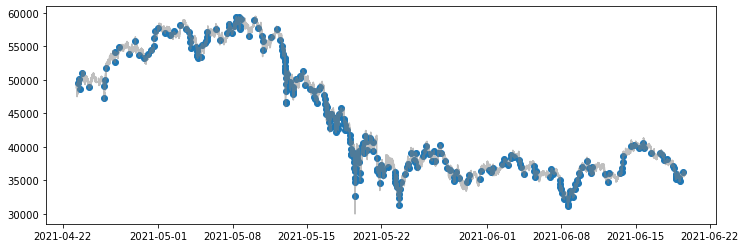

In [29]:
# test = df[a:b].reindex(t_events)
fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(clean_labels.index, df.close.reindex(clean_labels.index))
ax.plot(df.close, color="gray", alpha=.5)
# ax.scatter(test.index, test.close)

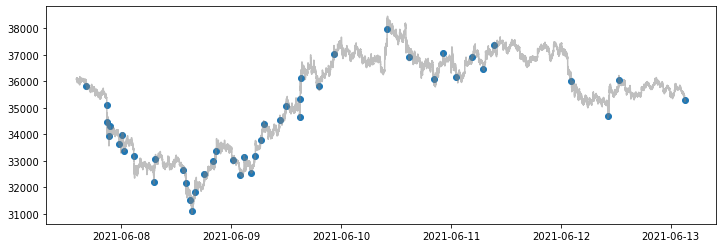

In [30]:
a = -200000
b = -100000
test = df[a:b].reindex(t_events)
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.close[a:b], color="gray", alpha=.5)
ax.scatter(test.index, test.close)

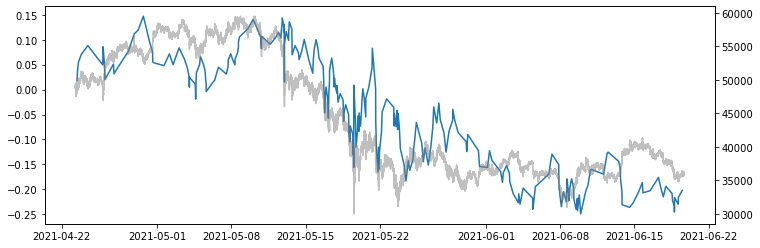

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(prediction.ret.cumsum())
ax1 = ax.twinx()
ax1.plot(df.close, color="gray", alpha=.5)

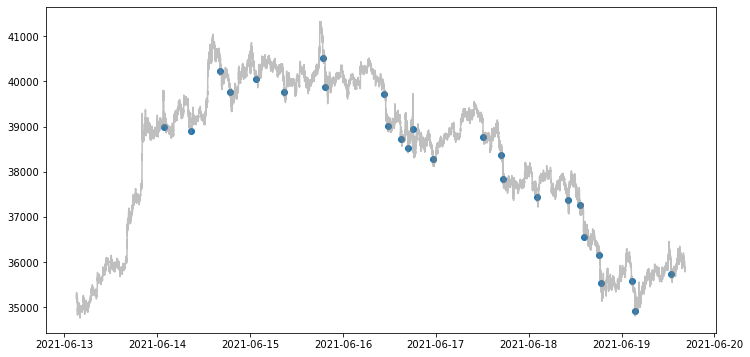

In [51]:
a = None
b = None
test = df[a:b].reindex(t_events)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.close[a:b], color="gray", alpha=.5)
ax.scatter(test.index, test.close)